In [1]:
import os
import struct
import pefile
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [2]:
file_path = "/home/mani/Desktop/main_project/data/DikeDataset/files/benign/0a8deb24eef193e13c691190758c349776eab1cd65fba7b5dae77c7ee9fcc906.exe"

In [3]:
PEfile = pefile.PE(file_path, fast_load=True)

required features
{
DebugSize
DebugRVA
ImageVersion
OperatingSystemVersion
SizeOfStackReserve
LinkerVersion
DllCharacteristics
IatRVA
ExportSize
ExportRVA
ExportNameLen
ResourceSize
ExportFunctionsCount
}


In [4]:
total_features = [PEfile.OPTIONAL_HEADER.DATA_DIRECTORY[6].Size, PEfile.OPTIONAL_HEADER.DATA_DIRECTORY[6].VirtualAddress, PEfile.OPTIONAL_HEADER.MajorImageVersion, PEfile.OPTIONAL_HEADER.MajorOperatingSystemVersion, PEfile.OPTIONAL_HEADER.DATA_DIRECTORY[0].VirtualAddress,
                  PEfile.OPTIONAL_HEADER.DATA_DIRECTORY[0].Size, PEfile.OPTIONAL_HEADER.DATA_DIRECTORY[12].VirtualAddress, PEfile.OPTIONAL_HEADER.DATA_DIRECTORY[2].Size, PEfile.OPTIONAL_HEADER.MajorLinkerVersion, PEfile.FILE_HEADER.NumberOfSections, PEfile.OPTIONAL_HEADER.SizeOfStackReserve, PEfile.OPTIONAL_HEADER.DllCharacteristics]
print(total_features)

[0, 0, 0, 4, 122880, 4045, 128508, 0, 2, 11, 2097152, 0]


In [ ]:
import os
import re
import pefile


def extract_header_info(file_path):
    PEfile = pefile.PE(file_path)
    machine_type = PEfile.FILE_HEADER.Machine
    num_sections = len(PEfile.sections)
    # file_size = os.path.getsize(file_path)
    entry_point = PEfile.OPTIONAL_HEADER.AddressOfEntryPoint
    return machine_type, num_sections, entry_point


def extract_section_info(file_path):
    PEfile = pefile.PE(file_path)
    section_info = [(section.Name.decode('utf-8').strip('\x00'),
                     section.SizeOfRawData) for section in PEfile.sections]
    return section_info


def extract_import_info(file_path):
    PEfile = pefile.PE(file_path)
    imports = {}
    for entry in PEfile.DIRECTORY_ENTRY_IMPORT:
        dll_name = entry.dll.decode('utf-8')
        imports[dll_name] = [func.name.decode(
            'utf-8') for func in entry.imports]
    return imports


def extract_strings(file_path):
    with open(file_path, 'rb') as f:
        data = f.read()
    # Extract ASCII and Unicode strings using regular expressions
    ascii_strings = re.findall(b'[ -~]{4,}', data)
    unicode_strings = re.findall(b'[\x20-\x7E\x80-\xFE]{4,}', data)
    return ascii_strings, unicode_strings


# Feature extraction functions (previously defined)


def extract_features(file_path):
    # Extract header information
    machine_type, num_sections,  entry_point = extract_header_info(file_path)

    # Extract section information
    section_info = extract_section_info(file_path)

    # Extract import information
    import_info = extract_import_info(file_path)

    # Extract ASCII and Unicode strings
    ascii_strings, unicode_strings = extract_strings(file_path)

    # Create a feature vector by concatenating all features
    feature_vector = [
        machine_type, num_sections,  entry_point,
        *section_info, import_info, len(ascii_strings), len(unicode_strings)
    ]

    return feature_vector


file_path = "/home/mani/Desktop/main_project/data/DikeDataset/files/benign/0a8deb24eef193e13c691190758c349776eab1cd65fba7b5dae77c7ee9fcc906.exe"
features = extract_features(file_path)

print(features)

In [ ]:
import os
import pefile
import re
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Feature extraction functions


def extract_header_info(PEfile):
    machine_type = PEfile.FILE_HEADER.Machine
    num_sections = len(PEfile.sections)
    entry_point = PEfile.OPTIONAL_HEADER.AddressOfEntryPoint
    return machine_type, num_sections,  entry_point


def extract_section_info(PEfile):
    section_info = [(section.Name.decode('utf-8').strip('\x00'),
                     section.SizeOfRawData) for section in PEfile.sections]
    return section_info


def extract_import_info(PEfile):
    imports = {}
    for entry in PEfile.DIRECTORY_ENTRY_IMPORT:
        dll_name = entry.dll.decode('utf-8')
        imports[dll_name] = [func.name.decode(
            'utf-8') for func in entry.imports]
    return imports


def extract_strings(file_path):
    with open(file_path, 'rb') as f:
        data = f.read()
    ascii_strings = re.findall(b'[ -~]{4,}', data)
    unicode_strings = re.findall(b'[\x20-\x7E\x80-\xFE]{4,}', data)
    return len(ascii_strings), len(unicode_strings)


# Directory paths
benign_dir = "/home/mani/Desktop/main_project/data/DikeDataset/files/benign"
malicious_dir = "/home/mani/Desktop/main_project/data/DikeDataset/files/malware"

# Feature extraction and data preparation
X = []
y = []

# Extract features from benign files
for file_name in tqdm(os.listdir(benign_dir)):
    file_path = os.path.join(benign_dir, file_name)
    try:
        PEfile = pefile.PE(file_path)
        features = list(extract_header_info(PEfile)) + list(extract_section_info(PEfile)
                                                            ) + [extract_import_info(PEfile)] + list(extract_strings(file_path))
        X.append(features)
        y.append(0)  # Benign label
    except Exception as e:
        print(f"file {file_name} caused error")
        print(e)
        continue

# # Extract features from malicious files
# for file_name in tqdm(os.listdir(malicious_dir)):
#     file_path = os.path.join(malicious_dir, file_name)
#     try:
#         PEfile = pefile.PE(file_path)
#         features = list(extract_header_info(PEfile)) + list(extract_section_info(PEfile)) + [extract_import_info(PEfile)] + list(extract_strings(file_path))
#         X.append(features)
#         y.append(1)  # Malicious label
#     except:
#         continue

X = np.array(X)
# y = np.array(y)

print(X.shape)

In [10]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a machine learning model (Random Forest in this example)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)
print(confusion)

Accuracy: 0.9838056680161943
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       104
           1       0.98      1.00      0.99       884

    accuracy                           0.98       988
   macro avg       0.99      0.93      0.95       988
weighted avg       0.98      0.98      0.98       988

[[ 89  15]
 [  1 883]]


In [2]:
import pandas as pd
import os
import pefile
import re
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [3]:
def get_features(file_path):
    # Extract header information
    PEfile = pefile.PE(file_path)
    feature_vector = [PEfile.OPTIONAL_HEADER.DATA_DIRECTORY[6].Size, PEfile.OPTIONAL_HEADER.DATA_DIRECTORY[6].VirtualAddress, PEfile.OPTIONAL_HEADER.MajorImageVersion, PEfile.OPTIONAL_HEADER.MajorOperatingSystemVersion, PEfile.OPTIONAL_HEADER.DATA_DIRECTORY[0].VirtualAddress,
                      PEfile.OPTIONAL_HEADER.DATA_DIRECTORY[0].Size, PEfile.OPTIONAL_HEADER.DATA_DIRECTORY[12].VirtualAddress, PEfile.OPTIONAL_HEADER.DATA_DIRECTORY[2].Size, PEfile.OPTIONAL_HEADER.MajorLinkerVersion, PEfile.FILE_HEADER.NumberOfSections, PEfile.OPTIONAL_HEADER.SizeOfStackReserve, PEfile.OPTIONAL_HEADER.DllCharacteristics]

    machine_type = PEfile.FILE_HEADER.Machine
    num_sections = len(PEfile.sections)
    entry_point = PEfile.OPTIONAL_HEADER.AddressOfEntryPoint
    feature_vector.extend([machine_type, num_sections,  entry_point])

    # Extract section information
    section_info = [section.SizeOfRawData for section in PEfile.sections]
    feature_vector += section_info

    # Extract ASCII and Unicode strings
    with open(file_path, 'rb') as f:
        data = f.read()
    ascii_strings = re.findall(b'[ -~]{4,}', data)
    unicode_strings = re.findall(b'[\x20-\x7E\x80-\xFE]{4,}', data)
    feature_vector.extend([len(ascii_strings), len(unicode_strings)])

    # Extract import information
    imports = {}
    for entry in PEfile.DIRECTORY_ENTRY_IMPORT:
        try:
            dll_name = entry.dll.decode('utf-8')
            imports[dll_name] = [func.name.decode(
                'utf-8') for func in entry.imports]
        except:
            dll_name = entry.dll
    feature_vector.extend(list(imports.keys()))

    return feature_vector


benign_dir = "/home/mani/Desktop/main_project/data/DikeDataset/files/benign"
malicious_dir = "/home/mani/Desktop/main_project/data/DikeDataset/files/malware"


df = pd.DataFrame(columns=['Name', 'MachineType', 'NumberOfSections', 'AddressOfEntryPoint',
                  'SizeOfRawData', 'NumberOfAsciiStrings', 'NumberOfUnicodeStrings', 'Imports', 'Label'])

for file_name in tqdm(os.listdir(benign_dir)):
    file_path = os.path.join(benign_dir, file_name)
    try:
        features = get_features(file_path)
        df.loc[len(df.index)] = [file_name, features[0], features[1],
                                 features[2], features[3], features[4], features[5], features[6], 0]
    except Exception as e:
        # print(f"file {file_name} caused error")
        # print(e)
        continue

for file_name in tqdm(os.listdir(malicious_dir)):
    file_path = os.path.join(malicious_dir, file_name)
    try:
        features = get_features(file_path)
        df.loc[len(df.index)] = [file_name, features[0], features[1],
                                 features[2], features[3], features[4], features[5], features[6], 1]
    except Exception as e:
        # print(f"file {file_name} caused error")
        # print(e)
        continue

# label encoding
# df['Imports'] = le.fit_transform(df['Imports'])

# import joblib
# joblib.dump(le, 'label_encoder_fids.pkl')


100%|██████████| 10841/10841 [08:03<00:00, 22.42it/s]


In [4]:
df.to_csv('../data/csv/pe_data_revision2.csv', index=False)

In [17]:
df.head()

,Name,MachineType,NumberOfSections,AddressOfEntryPoint,SizeOfRawData,NumberOfAsciiStrings,NumberOfUnicodeStrings,Imports,Label
0,3df47f4ebe158f4394bd3e0c2052262e92192998c0637c...,28,1156064,0,5,0,0,636,0
1,d5fd9c5ec6349c8c55cbad05095b97ee2939f24a45e40f...,28,22304,0,5,0,0,80,0
2,f62c18b00f87907a37c167dea4774e62593f769f796880...,56,14492,0,5,0,0,2,0
3,02253301617f5201605443ec0c4ab9e3bf8667caa3ea57...,0,0,0,4,0,0,241,0
4,432abbae25f6b91a977bc9f75c4a8edd3bffa5d152d67e...,56,4176,10,10,0,0,51,0


<Axes: >

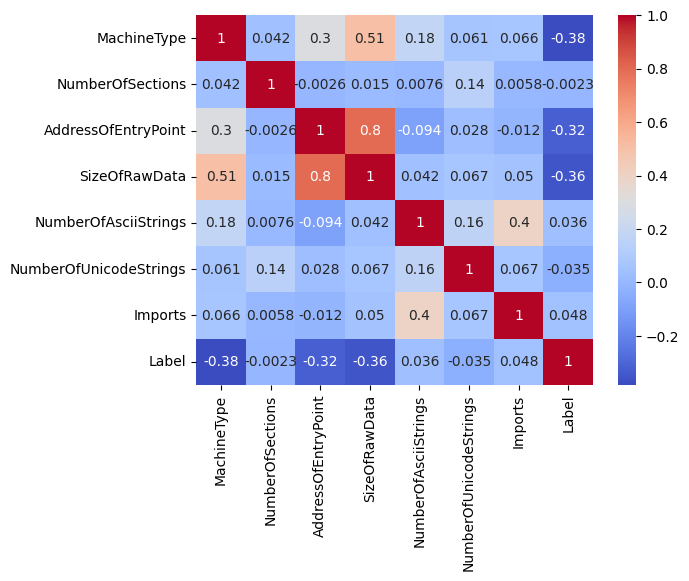

In [19]:
data = df.drop(['Name'], axis=1)

corr_matrix = data.corr()
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True)


In [ ]:
X = df.drop(['Name', 'Label'], axis=1)
y = df['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

print(f"x train shape: {X_train.shape}")
print(f"x test shape: {X_test.shape}")
print(f"y train shape: {y_train.shape}")
print(f"y test shape: {y_test.shape}")

In [15]:
pe_data = pd.read_csv("../data/csv/pe_data.csv")
X = pe_data.drop(['Name', 'Label'], axis=1)
y = pe_data['Label']

# print no. of benign and malicious files
print(f"Number of benign files: {len(y[y == 0])}")
print(f"Number of malicious files: {len(y[y == 1])}")

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=42)


Number of benign files: 932
Number of malicious files: 8944


accuracy of RandomForestClassifier: 0.9838056680161943
[[ 89  15]
 [  1 883]]


accuracy of LogisticRegression: 0.9190283400809717
[[ 28  76]
 [  4 880]]


accuracy of DecisionTreeClassifier: 0.9848178137651822
[[ 90  14]
 [  1 883]]


accuracy of GradientBoostingClassifier: 0.979757085020243
[[ 87  17]
 [  3 881]]


accuracy of AdaBoostClassifier: 0.9352226720647774
[[ 47  57]
 [  7 877]]


accuracy of GaussianNB: 0.8795546558704453
[[  4 100]
 [ 19 865]]




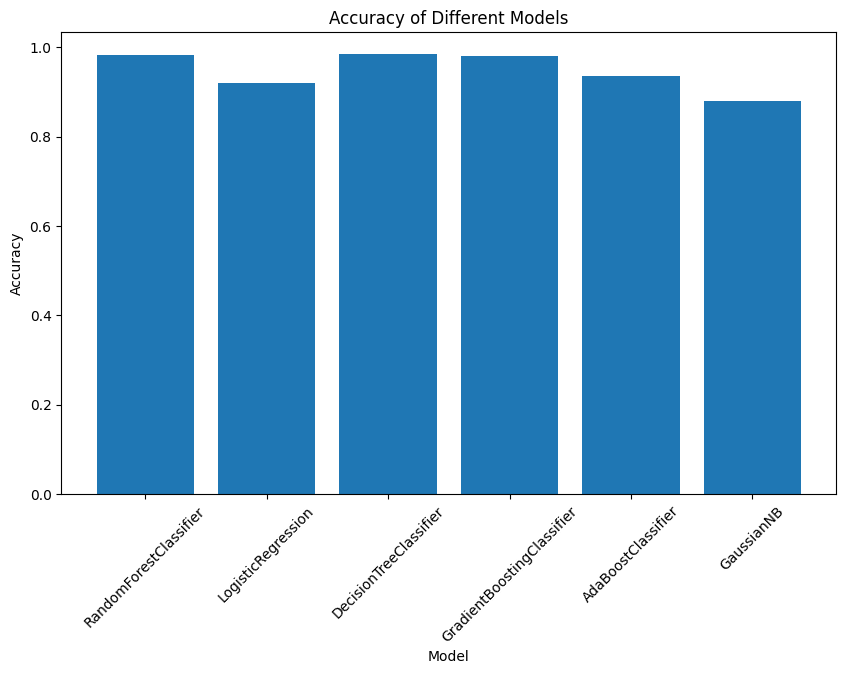

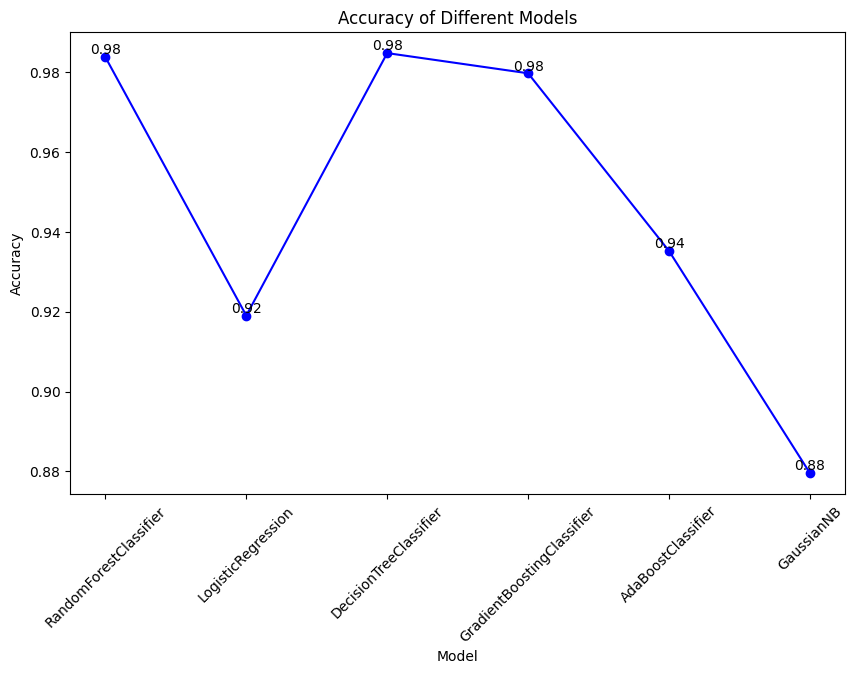

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

models = [
	RandomForestClassifier(n_estimators=100, random_state=42),
	LogisticRegression(),
	DecisionTreeClassifier(),
	GradientBoostingClassifier(),
	AdaBoostClassifier(),
	GaussianNB()
]

accuracies = []

for model in models:
	if isinstance(model, LogisticRegression):
		scaler = StandardScaler()
		X_train_scaled = scaler.fit_transform(X_train)
		X_test_scaled = scaler.transform(X_test)
		model.fit(X_train_scaled, y_train)
		y_pred = model.predict(X_test_scaled)
	else:
		model.fit(X_train, y_train)
		y_pred = model.predict(X_test)
	accuracy = accuracy_score(y_test, y_pred)
	accuracies.append(accuracy)

	print(
		f"accuracy of {model.__class__.__name__}: {accuracy_score(y_test, y_pred)}")
	print(confusion_matrix(y_test, y_pred))
	print("\n")

#  plot the accuracy of each model
model_names = [model.__class__.__name__ for model in models]
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.xticks(rotation=45)
plt.show()

#  plot the relative plot for model accuracy
plt.figure(figsize=(10, 6))
plt.plot(model_names, accuracies, marker='o', linestyle='-', color='blue')
for i, j in zip(model_names, accuracies):
	plt.text(i, j, str(round(j, 2)), ha='center', va='bottom', color='black')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.xticks(rotation=45)
plt.show()